<center><h1><b> Markowitz Efficient Frontier

In [ ]:
"""
-----------------------------------------------------------------------
        Author:    Giulio Fantuzzi
       Created:    2022/08/02
 Last modified:    2023/02/23

     Copyright (C) 2022  Giulio Fantuzzi
----------------------------------------------------------------------- 
"""

### Import data from web and get a brief overview of them

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import pandas_datareader
from pandas_datareader import data as pdr
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yfin
yfin.pdr_override()
from math import sqrt

#before importing it might need to pip install pandas-datareader and pip install yfinance

In [2]:
#Get the stock tickers in the portfolio
assets=['META', 'CEVA', 'ZOM', 'GOOG']

In [3]:
#Get the stock/portfolio dates (e.g. January 2021)
stockStartDate= '2023-01-01'
stockEndDate= '2023-02-22'

In [4]:
#Create a dataframe to store the (daily) adjusted close price of the stocks
#Data will be imported from yahoo finance
stocks= pd.DataFrame()
for stock in assets:
    stocks[stock]= pdr.get_data_yahoo(stock,start=stockStartDate,end=stockEndDate)['Adj Close']
#Visualize our dataframe
stocks

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,META,CEVA,ZOM,GOOG
Date,,,,
2023-01-03 00:00:00-05:00,124.739998,25.290001,0.160,89.699997
2023-01-04 00:00:00-05:00,127.370003,25.830000,0.169,88.709999
2023-01-05 00:00:00-05:00,126.940002,25.490000,0.192,86.769997
2023-01-06 00:00:00-05:00,130.020004,26.440001,0.234,88.160004
2023-01-09 00:00:00-05:00,129.470001,27.590000,0.250,88.800003
2023-01-10 00:00:00-05:00,132.990005,29.230000,0.250,89.239998
2023-01-11 00:00:00-05:00,132.889999,29.490000,0.241,92.260002
2023-01-12 00:00:00-05:00,136.710007,29.879999,0.250,91.910004
2023-01-13 00:00:00-05:00,136.979996,30.510000,0.250,92.800003


## Returns

### $$r_t = \frac{p_t}{p_{t-1}}$$

In [5]:
returns= stocks/stocks.shift(1)

### To make our data comparable, let's consider log returns



In [6]:
logReturns= np.log(returns)
logReturns

,META,CEVA,ZOM,GOOG
Date,,,,
2023-01-03 00:00:00-05:00,NaN,NaN,NaN,NaN
2023-01-04 00:00:00-05:00,0.020865,0.021128,0.054725,-0.011098
2023-01-05 00:00:00-05:00,-0.003382,-0.013250,0.127597,-0.022112
2023-01-06 00:00:00-05:00,0.023974,0.036592,0.197826,0.015892
2023-01-09 00:00:00-05:00,-0.004239,0.042575,0.066140,0.007233
2023-01-10 00:00:00-05:00,0.026825,0.057742,0.000000,0.004943
2023-01-11 00:00:00-05:00,-0.000752,0.008856,-0.036664,0.033281
2023-01-12 00:00:00-05:00,0.028340,0.013138,0.036664,-0.003801
2023-01-13 00:00:00-05:00,0.001973,0.020865,0.000000,0.009637


### Sharp ratio


$$ SR(w)= \frac{R(w)-R_f}{\sigma(w)}, \text{ with } w=[w_1 w_2 w_3 w_4 w_5] \text{ s.t. } \sum_{k=1}^{5}{w_k}=1$$ 

Since we will look for max $SR(w)$ and $R_f$ is common for all $w$, then we shall compute

\begin{align*}
R(w) &= w^T log(r)\\[0.4cm]
\sigma(w) &= \sqrt{w^T S w}\\[0.4cm]
SR(w) &\sim \frac{R(w)}{\sigma(w)}
\end{align*}

# Expected optimal weights by Monte Carlo simulation

In [7]:
#We're gonna create lots of different portfolios
numberOfPortfolios= 10000
#Pre allocating a weight matrix
weight= np.zeros((numberOfPortfolios,len(assets)))

meanLogReturn= logReturns.mean() #it's an array with the meanlogreturn for each company
S= logReturns.cov()

expectedReturn=np.zeros(numberOfPortfolios)
expectedVolatility=np.zeros(numberOfPortfolios)
expectedSR=np.zeros(numberOfPortfolios)


for k in range(numberOfPortfolios):
    
    #Generate random weight vector
    w=np.array(np.random.random(len(assets)))
    w= w/np.sum(w)
    weight[k,:]=w
    #Expected return (actually it's the log expected return)
    expectedReturn[k]= np.dot(meanLogReturn,w)
    #Expected volatility
    expectedVolatility[k]= np.sqrt(np.dot(w.T,np.dot(S,w)))
    #Expected SR (actually it's not the SR, but it's proportionally)
    expectedSR[k]= expectedReturn[k]/expectedVolatility[k]

In [8]:
#the best portfolio is the one with the higher SR
maxIndex= expectedSR.argmax()

#From which we can "deduce" the optimal portfolio weights
expectedoptimalWeights= weight[maxIndex,:]
expectedoptimalWeights

array([0.24146408, 0.52768008, 0.22910087, 0.00175498])

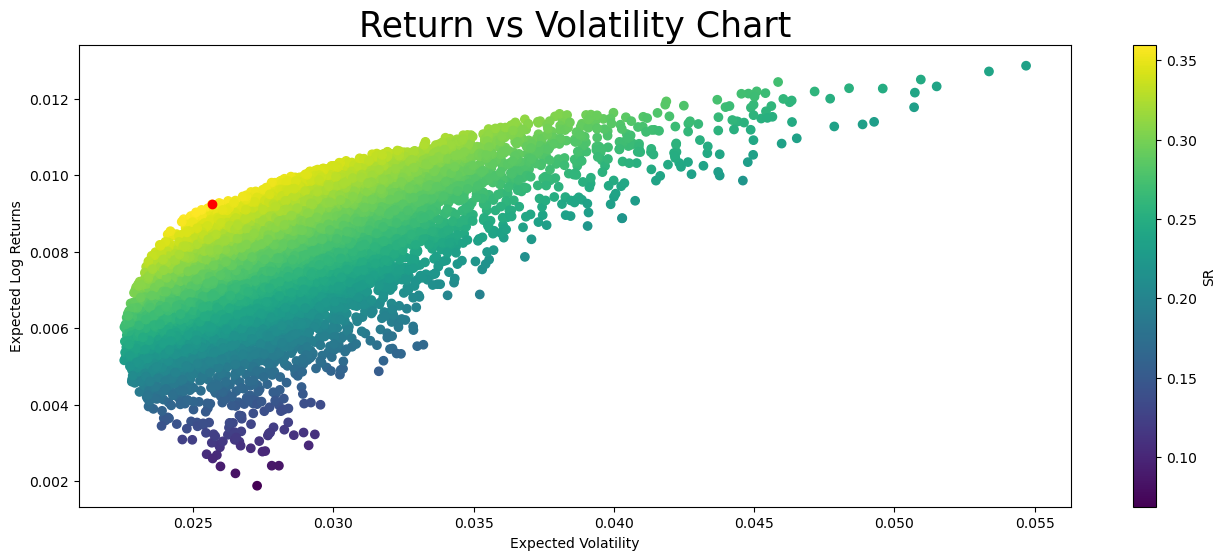

In [9]:
plt.figure(figsize=(16,6))
plt.scatter(expectedVolatility, expectedReturn, c=expectedSR)
plt.title('Return vs Volatility Chart', fontsize=25)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Log Returns')
plt.colorbar(label='SR')
plt.scatter(expectedVolatility[maxIndex], expectedReturn[maxIndex], color='r') #optimal simultated porfolio (max SR)
plt.show()

# Optimal weights by Markowitz Portfolio Optimization 

Our optimization problem can be represented as follow:


\begin{align*}
\min_{w} \quad & -SR(w)\\
\textrm{s.t.} \quad & 0 \leq w_{i}\leq 1\;\;\forall i\\
                    & 1^T w=1 \;\;\;\;\;\; (\text{it means } \sum_{i} w_i=1 ) \\
\end{align*}

In fact finding the max of the function SR is the same of finding the min of the function -SR


In [10]:
#we need a library for optimization
#similarry to matlab, the sintax is of the type (objfunc, initialguess, alg, bounds, constraints)
from scipy.optimize import minimize

#Function to minimize
#--------------------------------------
def negativeSR(w):
    w=np.array(w)
    R=np.sum(meanLogReturn*w)
    V=np.sqrt(np.dot(w.T,np.dot(S,w)))
    SR= R/V
    return -1*SR
#--------------------------------------
#Function of the costraints
def checkSumToOne(w):
    return (np.sum(w)-1)
#--------------------------------------
#Initial Guess, bounds and costraints
w0=[0.25, 0.25, 0.25, 0.25]
bounds=((0,1),(0,1),(0,1),(0,1))
constraints= ({'type':'eq', 'fun': checkSumToOne})
#--------------------------------------


w_opt= minimize(negativeSR, w0, method='SLSQP',bounds=bounds, constraints=constraints)
w_opt

     fun: -0.3604728664079292
     jac: array([-5.33871353e-05, -2.71499157e-05,  1.31059438e-04,  2.13551704e-01])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([2.34051445e-01, 5.55529295e-01, 2.10419260e-01, 1.19587500e-16])

In [11]:
#Optimal weights, volatility and logreturn
optimalWeights=w_opt.x
vol_opt=np.sqrt(np.dot(optimalWeights.T,np.dot(S,optimalWeights)))
ret_opt=np.sum(meanLogReturn*optimalWeights)

optimalWeights

array([2.34051445e-01, 5.55529295e-01, 2.10419260e-01, 1.19587500e-16])

# Scatter plot frontier

In [12]:
#Get the frontier
returns=np.linspace(0,0.11,50)
volatility_opt=[]
def minimizeMyVolatility(w):
    w=np.array(w)
    V=np.sqrt(np.dot(w.T,np.dot(S,w)))
    return V
def getReturn(w):
    w=np.array(w)
    R= np.sum(meanLogReturn*w)
    return R
for R in returns:
    #find best volatility
    constraints=({'type':'eq', 'fun': checkSumToOne},
                 {'type':'eq', 'fun': lambda w: getReturn(w)-R}) #NB:lambda is a python way to get a handle funct!
    opt= minimize(minimizeMyVolatility, w0, method='SLSQP',bounds=bounds, constraints=constraints)
    volatility_opt.append(opt['fun'])



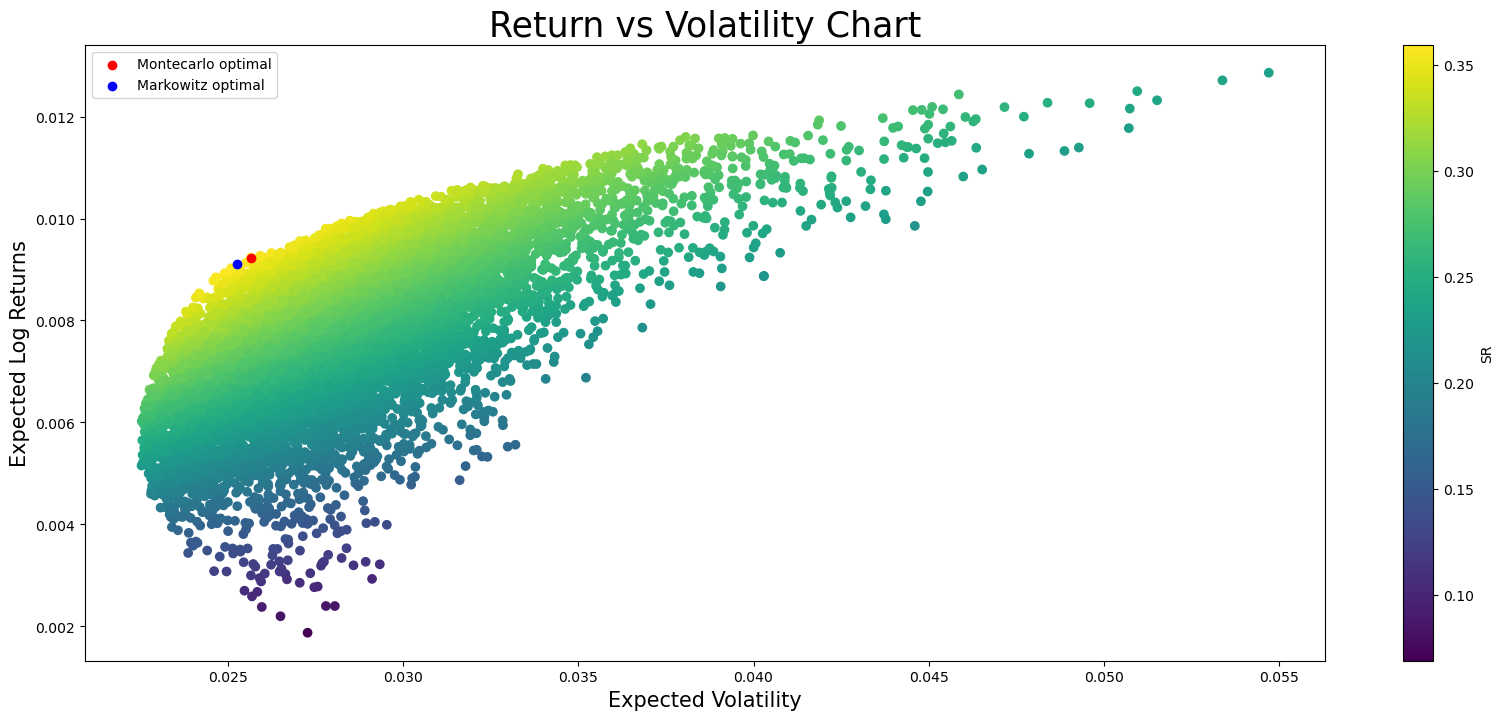

In [13]:
#Scatterplot we did before
#---------------------------------------------------------------------------------
plt.figure(figsize=(20,8))
plt.scatter(expectedVolatility, expectedReturn, c=expectedSR)
plt.title('Return vs Volatility Chart', fontsize=25)
plt.xlabel('Expected Volatility',fontsize=15)
plt.ylabel('Expected Log Returns',fontsize=15)
plt.colorbar(label='SR')

montecarlo_opt=plt.scatter(expectedVolatility[maxIndex], expectedReturn[maxIndex], color='r')#opt portfolio by montecarlo
markowitz_opt=plt.scatter(vol_opt, ret_opt, color='blue') #opt portfolio by markowitz optimization
plt.legend((montecarlo_opt,markowitz_opt),("Montecarlo optimal","Markowitz optimal"))
plt.show()

**Comment**: the 2 optimal points are almost overlapped. 

This suggests the efficiency of our montecarlo simulation!